In [1]:
# ----------------------------------------------------------------------------
#
# TITLE - triaxial_potential_DF.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Calculate the actions around the strange features in the triaxial DF
'''

__author__ = "James Lane"

In [97]:
## Imports

## Basic
import numpy as np
import sys, os, pdb
import copy
import time
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits

## galpy
from galpy import orbit
from galpy import potential
from galpy import df
from galpy.actionAngle import actionAngleAdiabatic
from galpy.actionAngle import actionAngleStaeckel
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.optimize import curve_fit

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.potential
import ast1501.util
import ast1501.fourier

In [7]:
# Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta

## Future work
- Go in depth into the functions that calculate the radial action

## Information
- Galpy notes on the DF: https://galpy.readthedocs.io/en/latest/diskdf.html
- Galpy notes on the actions: https://galpy.readthedocs.io/en/latest/actionAngle.html

# Prepare
Declare the keywords for the analysis, make the potential, and the DF

## Keywords and File Names

In [8]:
## Keywords and File Names

x_sun = -8.125

In [9]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

In [10]:
### Cut on galactocentric absolute Z < 0.3 kpc
where_low_z = np.where( np.abs(data['Z']) < 0.3 )[0]
data_low_z = data[where_low_z] 
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

In [11]:
### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = data_low_z['APOGEE_ID']
locid = data_low_z['LOCATION_ID']
vhelio = data_low_z['VHELIO']
pmll = data_low_z['PM_LL']
pmbb = data_low_z['PM_BB']
gc_x = data_low_z['X']
gc_y = data_low_z['Y']
gc_z = data_low_z['Z']
gc_vx = data_low_z['VX']
gc_vy = data_low_z['VY']
gc_vz = data_low_z['VZ']

In [12]:
### Convert to galactocentric radius and radial velocity
gc_R = np.sqrt(np.square(gc_x)+np.square(gc_y))
gc_phi = np.arctan2(gc_y,gc_x)
gc_vR = np.cos(gc_phi)*gc_vx + np.sin(gc_phi)*gc_vy
gc_vT = -np.sin(gc_phi)*gc_vx + np.cos(gc_phi)*gc_vy

## Tangential Velocity

In [88]:
sim_halo_data_b12 = np.load('data/data_R7.5-14.5_b12.npy')
print('\nRadii for b=1.2')
for i in range( sim_halo_data_b12.shape[0] ):
    print( str(sim_halo_data_b12[i][0])+' kpc' )
###i

sim_halo_data_b09 = np.load('data/data_R7.5-14.5_b09.npy')
print('\nRadii for b=0.9')
for i in range( sim_halo_data_b09.shape[0] ):
    print( str(sim_halo_data_b09[i][0])+' kpc' )
###i


Radii for b=1.2
7.5 kpc
8.5 kpc
9.5 kpc
10.5 kpc
11.5 kpc
12.5 kpc
13.5 kpc
14.5 kpc

Radii for b=0.9
7.5 kpc
8.5 kpc
9.5 kpc
10.5 kpc
11.5 kpc
12.5 kpc
13.5 kpc
14.5 kpc


In [84]:
# First decide on the radial bins
n_R_bins = 10
R_max = 15
R_min = 5
# R_range = np.linspace(R_min, R_max, n_R_bins, endpoint=False)
R_range = np.arange(7,15,1)
# R_bin_size = (R_max-R_min)/n_R_bins
R_bin_size = 1.0
R_range_cents = R_range + (R_bin_size/2)

# Make a galactic azimuth angle
gc_az = np.arctan2( -gc_x, -gc_y ) * 180 /  np.pi - 90

n_az_bins = 18
az_range = np.linspace(-90, 90, n_az_bins, endpoint=False)
az_bin_size = 180/n_az_bins
az_range_cents = az_range + (az_bin_size/2)

n_bs = 100

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)



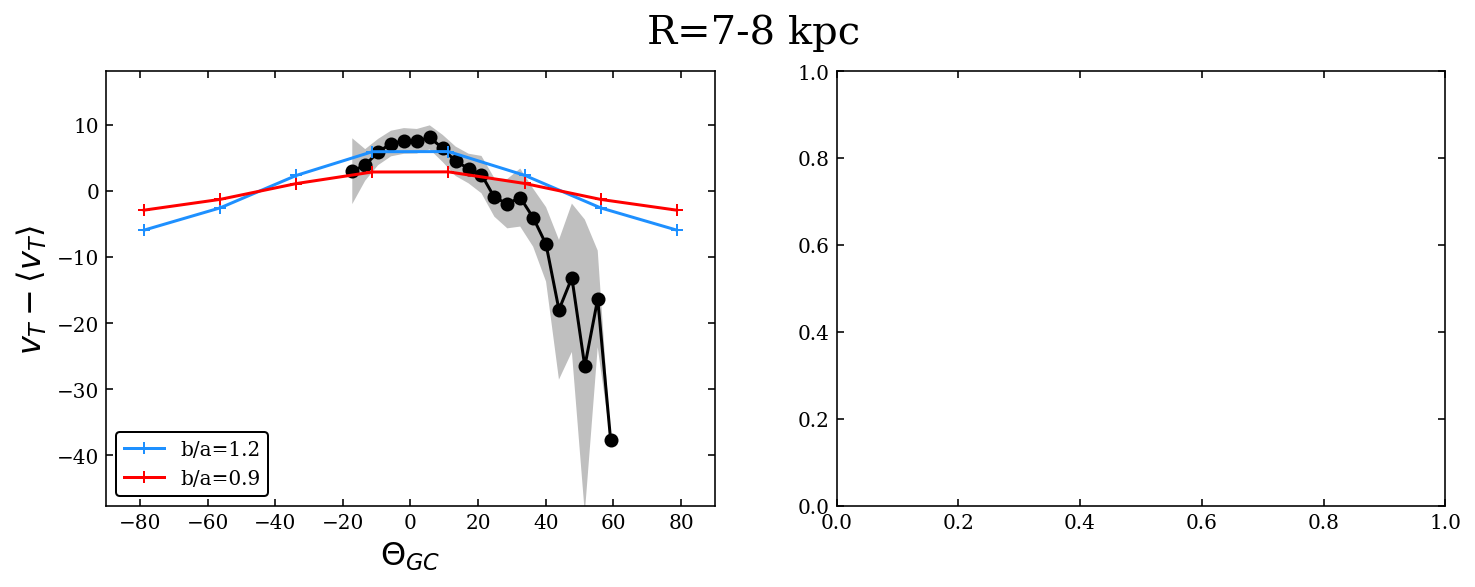

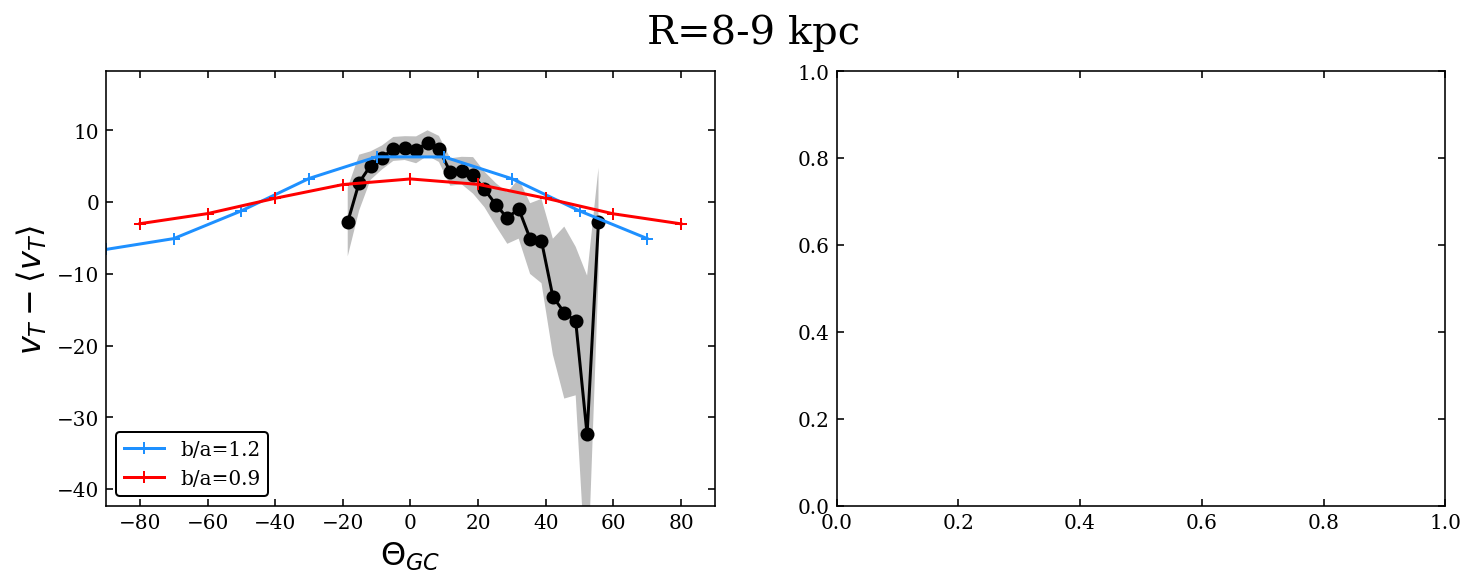

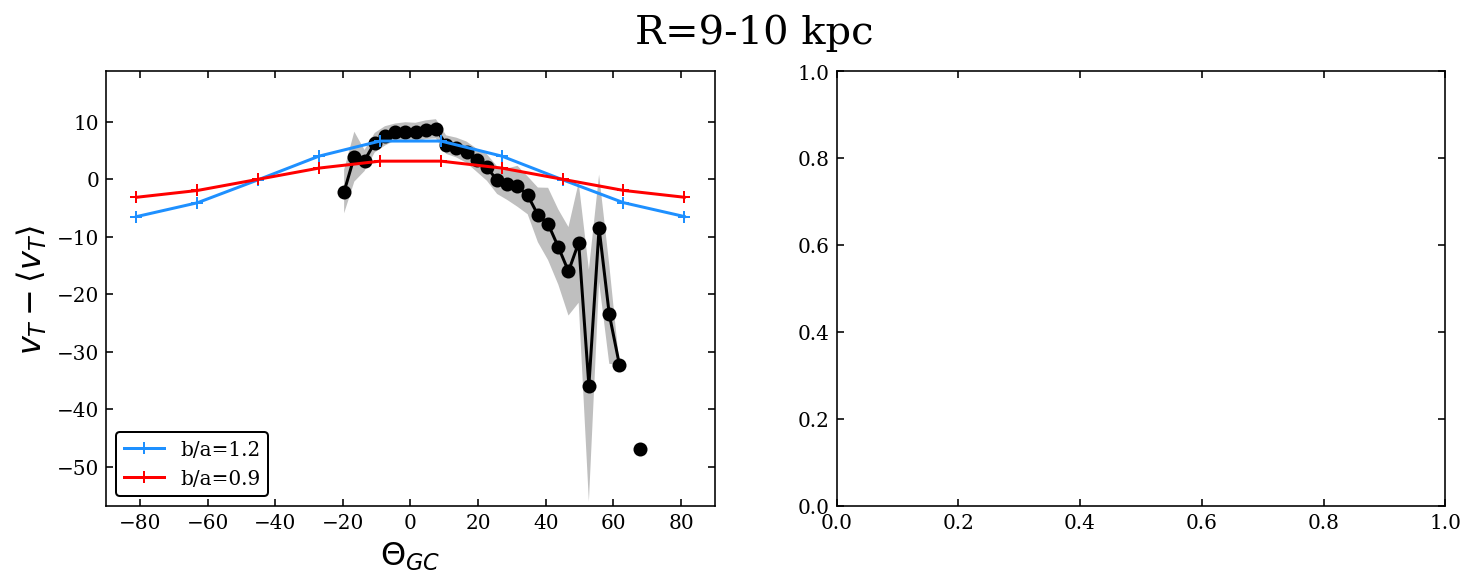

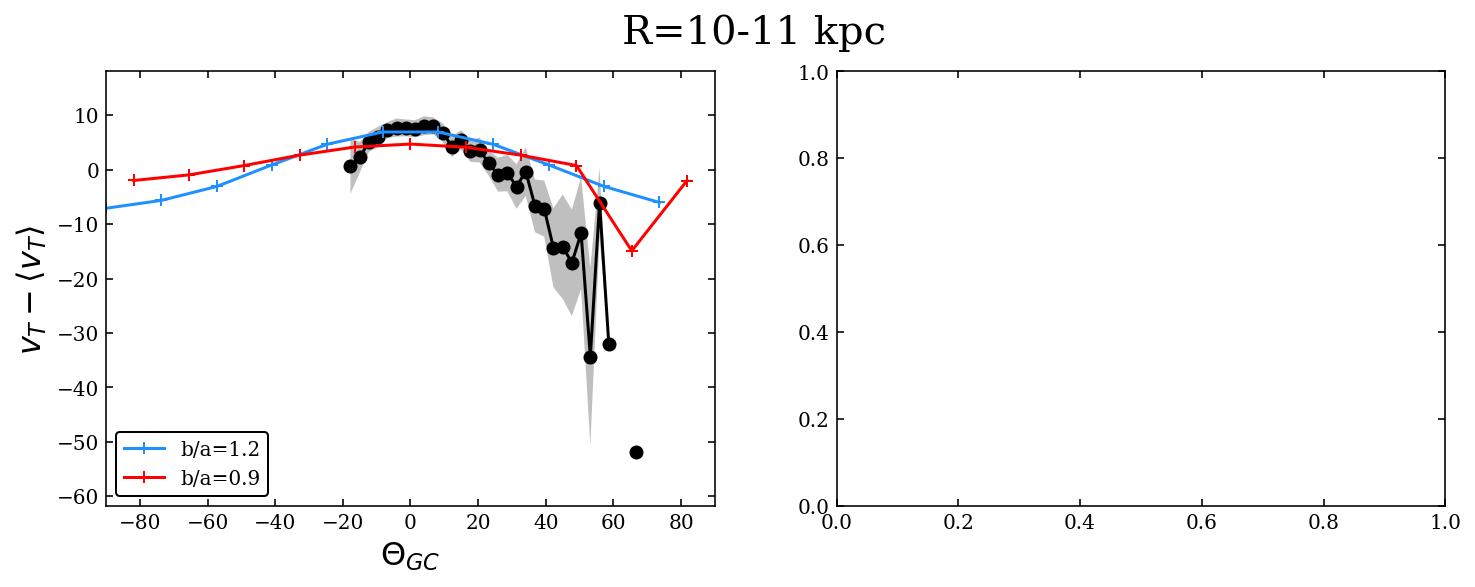

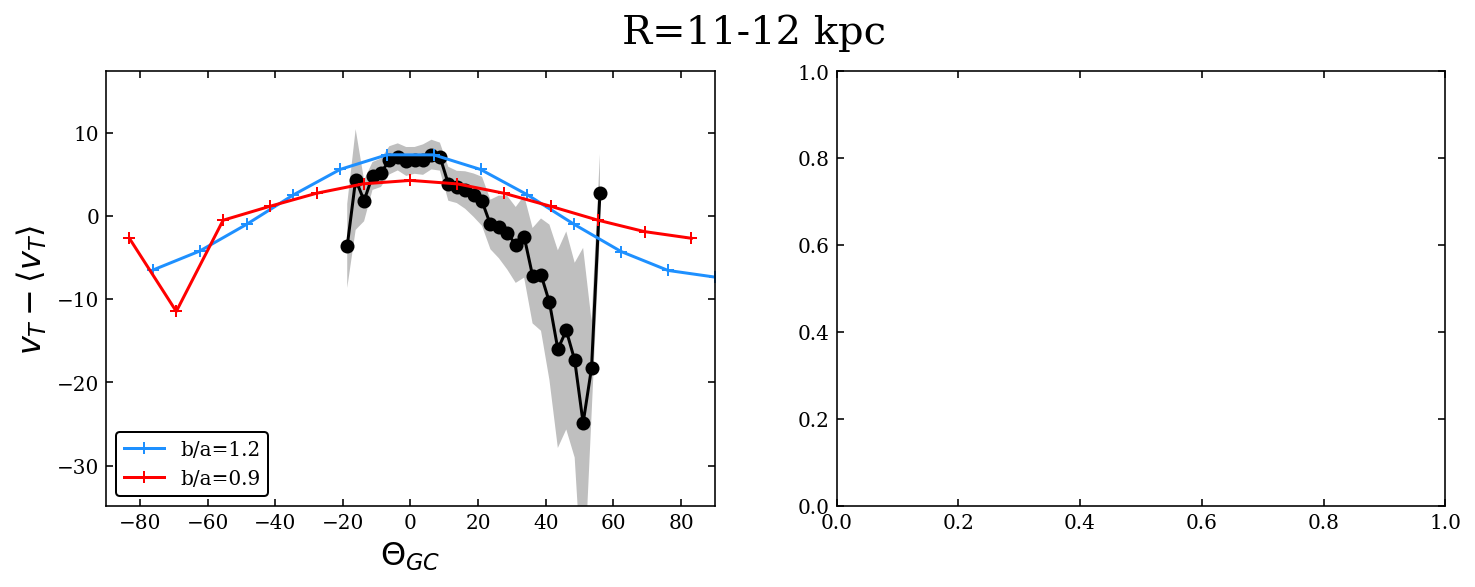

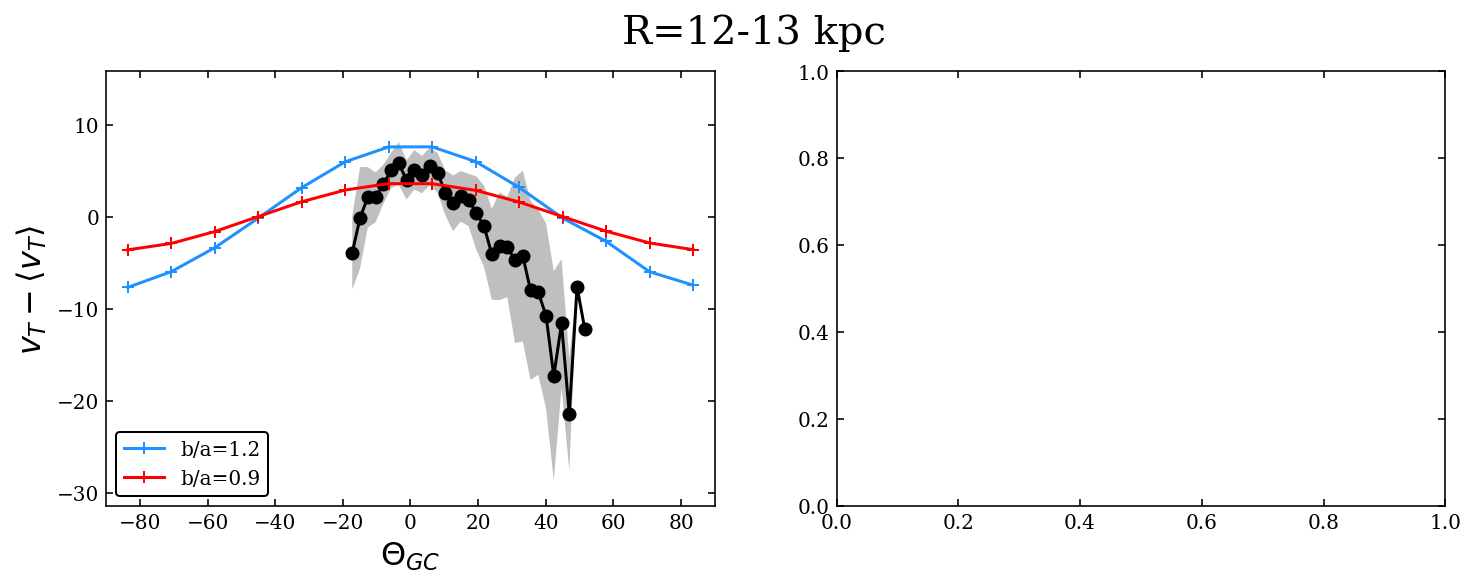

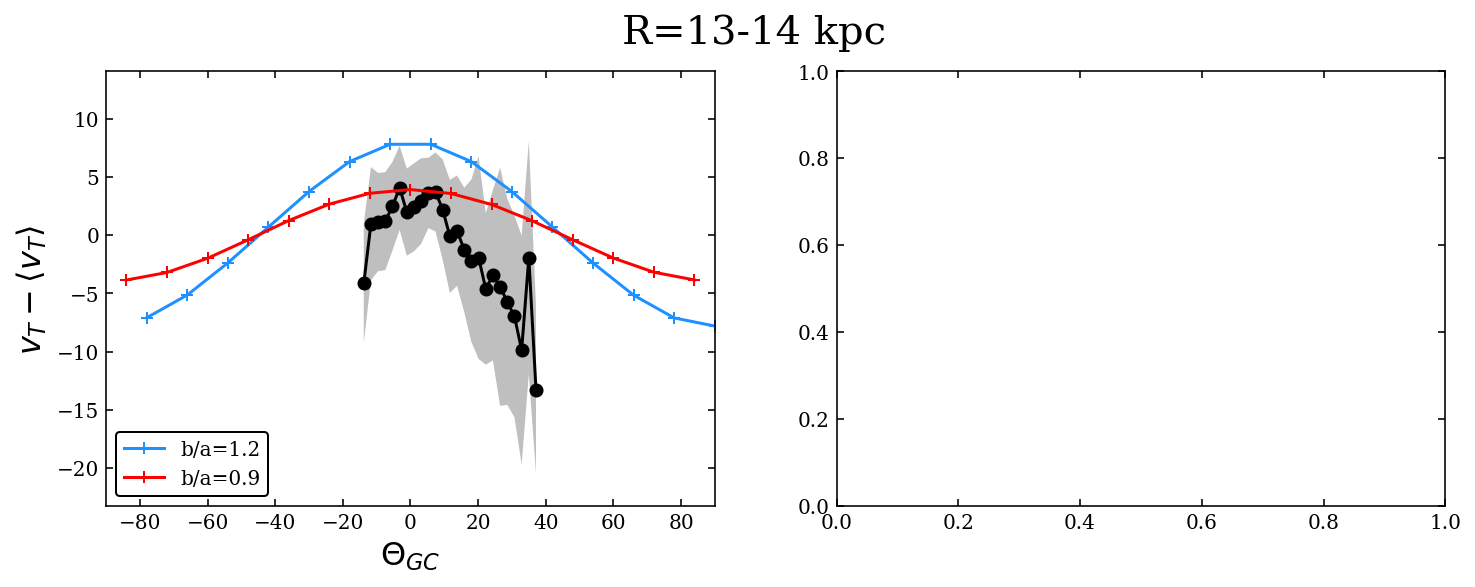

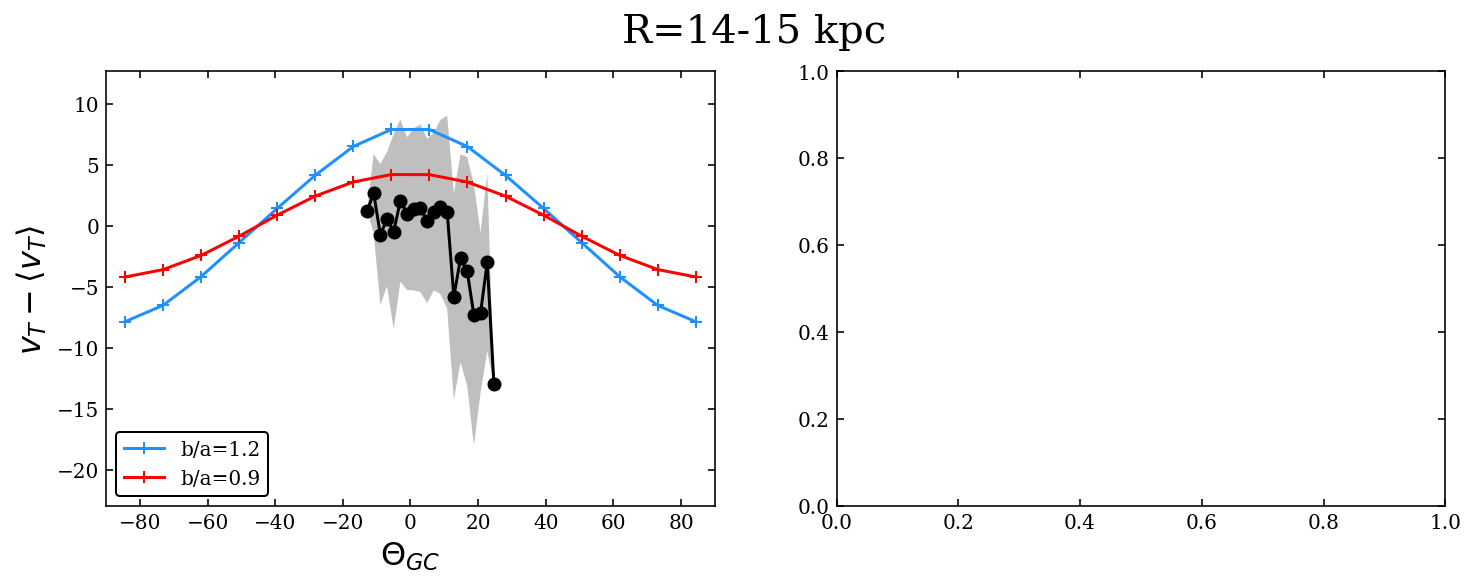

In [110]:
# Now loop over each radial bin
for i in range( len(R_range) ):
    
    # Bootstrap over the samples
    for j in range(n_bs):
        
        # Take a random sub-sample of Gaia stars
        sample = np.random.randint(0,len(gc_x),len(gc_x))
        samp_gc_R = gc_R[sample]
        samp_gc_az = gc_phi[sample]
        samp_gc_vT = gc_vT[sample]
        
        # Select the stars in this bin
        stars_in_bin = np.where(  (samp_gc_R > R_range[i]) & (samp_gc_R < (R_range[i]+R_bin_size) ) )[0]
        gcvt_in_bin = -gc_vT[stars_in_bin]
        gcaz_in_bin = gc_az[stars_in_bin]

        # Figure out the angular size of 0.5 kpc
        spec_az_size = 0.5/(R_range[i]+R_bin_size/2)
        n_az_bins = int( np.pi/180*(az_range[-1]-az_range[0]) /spec_az_size )
        az_low = -int(n_az_bins/2)*spec_az_size * 180/np.pi
        az_hi = (n_az_bins-int(n_az_bins/2))*spec_az_size * 180/np.pi

        # Bin in azimuth
        binned_vt, bin_edges, _ = binned_statistic(gcaz_in_bin, gcvt_in_bin, bins=n_az_bins, statistic='mean', 
                                                   range=(az_low, az_hi))
        vt_bin_cents = ( bin_edges[:-1] + bin_edges[1:] ) / 2

        # Make a number histogram to examine whether there is enough stars for a valid measurement
        binned_n, binned_n_edges, = np.histogram(gcaz_in_bin, bins=n_az_bins, range=(az_low, az_hi))
        where_low_bin_numbers = np.where(binned_n < 10)
        binned_vt[where_low_bin_numbers] = np.nan

        # Find where there was data
        # pdb.set_trace()
        where_data = np.where( np.isfinite(binned_vt) )
        where_no_data = np.where( np.isnan(binned_vt) )
        binned_vt[ where_no_data ] = np.nan

        # Subtract off mean where non-zero
        mean_binned_vt = np.nanmean( binned_vt[where_data] )
        binned_vt = binned_vt - mean_binned_vt
#         binned_vt[where_no_data] = 0
    
        # Get the power spectrum
        ks, pk, phase = ast1501.fourier.psd(binned_vt, az_bin_size*np.pi/180, pad=True, return_phase=True)
        
        if j == 0:
            bs_az = np.zeros((n_bs, len(vt_bin_cents)))
            bs_vT = np.zeros((n_bs, len(binned_vt)))
            bs_k_vT = np.zeros((n_bs, len(ks)))
            bs_pk_vT = np.zeros((n_bs, len(pk)))
        ##fi
        bs_az[j] = vt_bin_cents
        bs_vT[j] = binned_vt
        bs_k_vT[j] = ks
        bs_pk_vT[j] = pk
    
    
    # Take the average and standard deviation of the azimuthal profile
    bs_avg_vT = np.nanmean(bs_vT, axis=0)
    bs_std_vT = np.nanstd(bs_vT, axis=0)
    
    # Take the average and standard deviation of the power spectrum
    bs_avg_pk_vT = np.nanmean(bs_pk_vT, axis=0)
    bs_std_pk_vT = np.nanstd(bs_pk_vT, axis=0)
    
    # Plot
    fig = plt.figure( figsize=(12,4) )
    ax1, ax2 = fig.subplots(nrows=1, ncols=2)
    
    ax1.plot(bs_az[0], bs_avg_vT, color='Black', marker='o')
    ax1.fill_between( bs_az[0], bs_avg_vT+bs_std_vT, bs_avg_vT-bs_std_vT, alpha=0.5, facecolor='Grey' )
    
    ax1.set_xlabel(r'$\Theta_{GC}$', fontsize=16)
    ax1.set_ylabel(r'$v_{T}- \langle {v_{T}} \rangle$', fontsize=16)
    ax1.set_xlim(-90,90)
    ax1.set_ylim( np.nanmin(bs_avg_vT)-10, np.nanmax(bs_avg_vT)+10 )
    
    # Look for the simulation data for b=1.2
    index_radius = 0
    for k in range( sim_halo_data_b12.shape[0] ):
        if sim_halo_data_b12[k][0] == R_range_cents[i]:
            index_radius = k
        ##fi
    ###k
    
    sim_vt_data_b12 = sim_halo_data_b12[index_radius][3]
    sim_vt_data_b12 -= np.mean(sim_vt_data_b12)
    sim_az_data_b12 = sim_halo_data_b12[index_radius][1] * 180/np.pi
    
    # Apply a phase shift
    phase_shift = 90
    sim_az_data_b12 += phase_shift
    for l in range( len(sim_vt_data_b12) ):
        if sim_az_data_b12[l] >= 90:
            sim_az_data_b12[l] -= 180
        ##fi
    ###i
    sort_sim_az_data_b12 = np.argsort(sim_az_data_b12)
    sim_vt_data_b12 = sim_vt_data_b12[sort_sim_az_data_b12]
    sim_az_data_b12 = sim_az_data_b12[sort_sim_az_data_b12]
    
    ax1.plot(sim_az_data_b12, sim_vt_data_b12, color='DodgerBlue', marker='+', label='b/a=1.2')
    
    
    
    
    # Look for the simulation data for b=0.8
    index_radius = 0
    for k in range( sim_halo_data_b09.shape[0] ):
        if sim_halo_data_b09[k][0] == R_range_cents[i]:
            index_radius = k
        ##fi
    ###k
    
    sim_vt_data_b09 = sim_halo_data_b09[index_radius][3]
    sim_vt_data_b09 -= np.mean(sim_vt_data_b09)
    sim_az_data_b09 = sim_halo_data_b09[index_radius][1] * 180/np.pi
    
    # Apply a phase shift
    phase_shift = 0
    sim_az_data_b09 += phase_shift
    for l in range( len(sim_vt_data_b09) ):
        if sim_az_data_b09[l] >= 90:
            sim_az_data_b09[l] -= 180
        ##fi
    ###i
    sort_sim_az_data_b09 = np.argsort(sim_az_data_b09)
    sim_vt_data_b09 = sim_vt_data_b09[sort_sim_az_data_b09]
    sim_az_data_b09 = sim_az_data_b09[sort_sim_az_data_b09]
    
    ax1.plot(sim_az_data_b09, sim_vt_data_b09, color='Red', marker='+', label='b/a=0.9')
    
    ax1.legend(loc='lower left')
    
#     ax2.plot(np.log10(ks[round(len(ks)/2)+1:]), np.sqrt(4*np.pi*pk[round(len(ks)/2)+1:]), color='Black', marker='o')
#     ax2.set_xlabel(r'$k$', fontsize=16)
#     ax2.set_ylabel('Power', fontsize=16)
#     ax2.set_ylim(0,10)
    
#     ax3.plot( np.log10(ks[round(len(ks)/2)+1:]), phase[round(len(ks)/2)+1:], color='Black', marker='o')
#     ax3.set_xlabel(r'$k$', fontsize=16)
#     ax3.set_ylabel('Phase', fontsize=16)
    
    fig.suptitle('R='+str(int(R_range[i]))+'-'+str(int(R_range[i]+R_bin_size))+' kpc', fontsize=20)
    
    plt.show()
    plt.close('all')
###i

## Radial Velocity

In [111]:
# First decide on the radial bins
n_R_bins = 10
R_max = 15
R_min = 5
# R_range = np.linspace(R_min, R_max, n_R_bins, endpoint=False)
R_range = np.arange(7,15,1)
# R_bin_size = (R_max-R_min)/n_R_bins
R_bin_size = 1.0
R_range_cents = R_range + (R_bin_size/2)

# Make a galactic azimuth angle
gc_az = np.arctan2( -gc_x, -gc_y ) * 180 /  np.pi - 90

n_az_bins = 18
az_range = np.linspace(-90, 90, n_az_bins, endpoint=False)
az_bin_size = 180/n_az_bins
az_range_cents = az_range + (az_bin_size/2)

n_bs = 100

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice

/Users/JamesLane/Software/Python/anaconda3/envs/ast1501-dev/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)



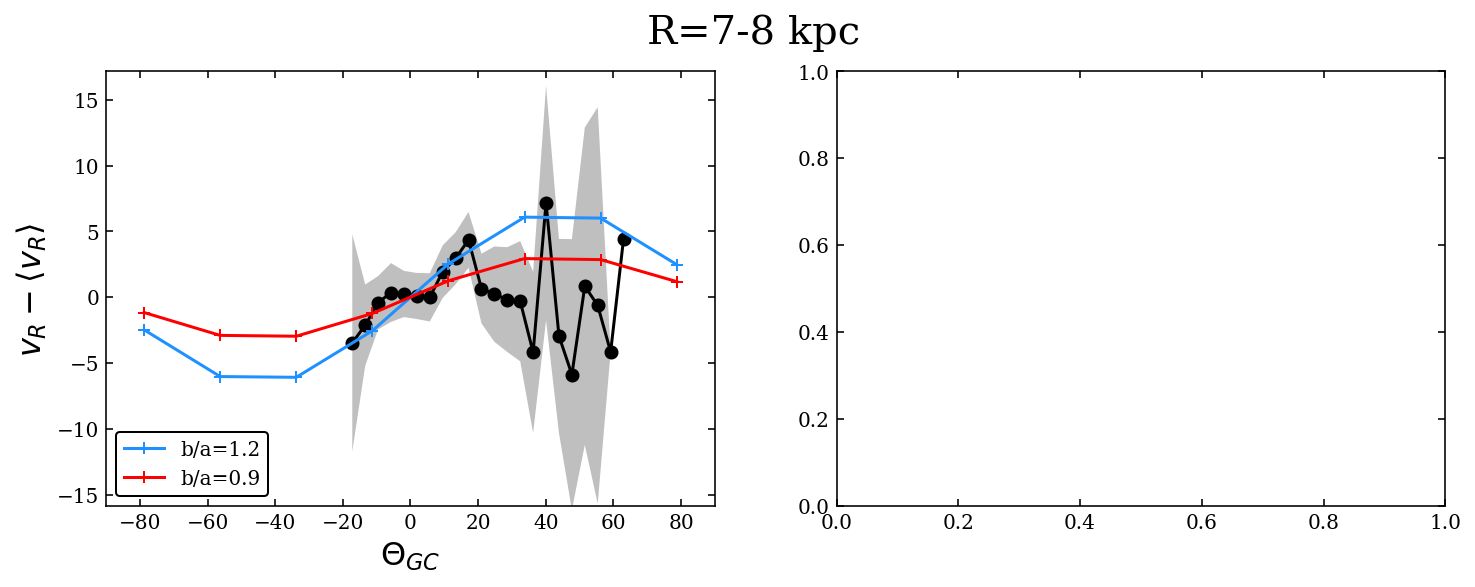

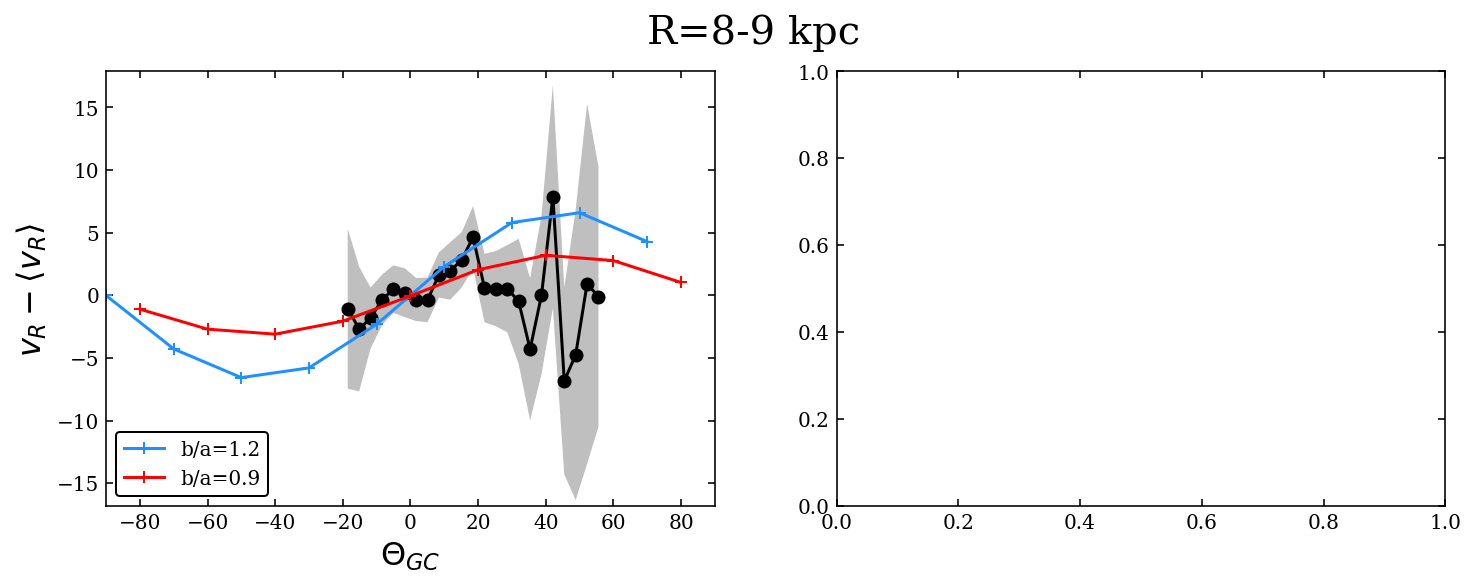

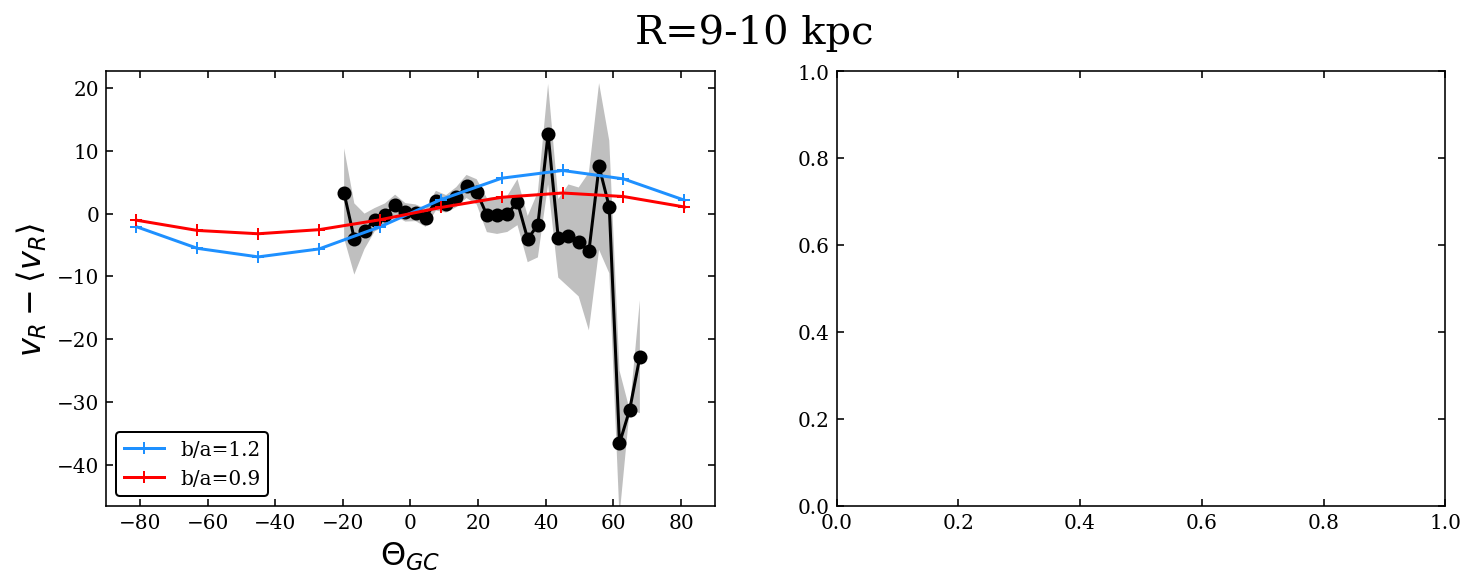

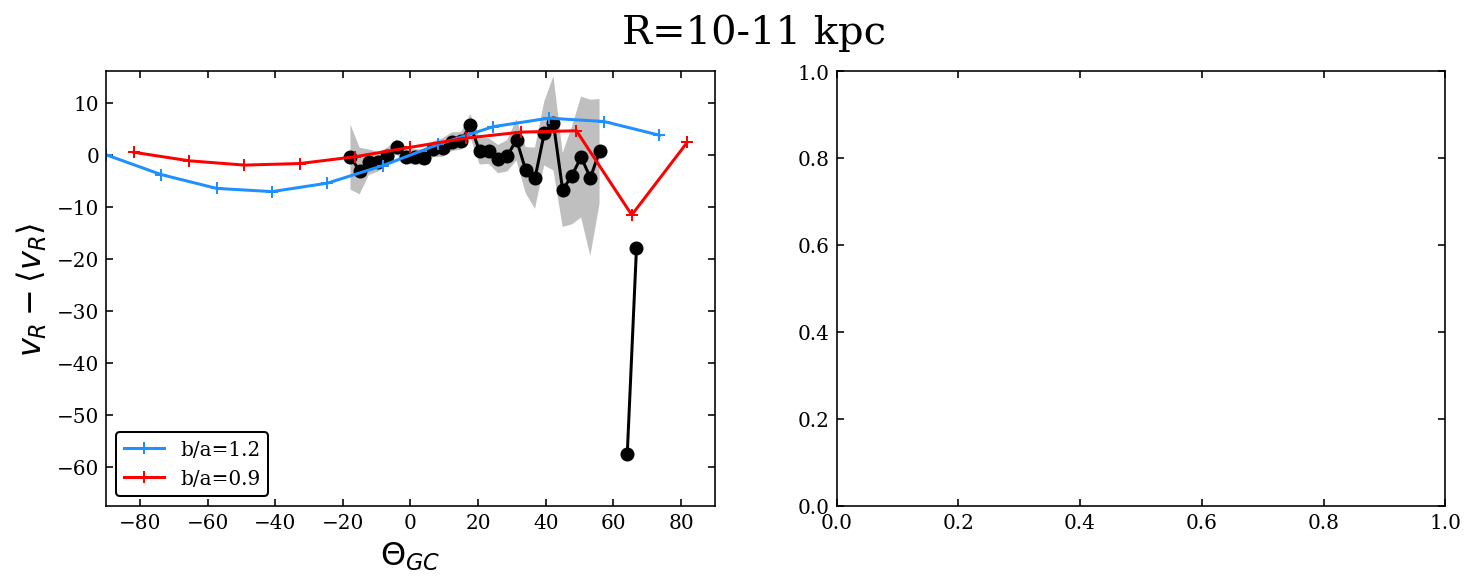

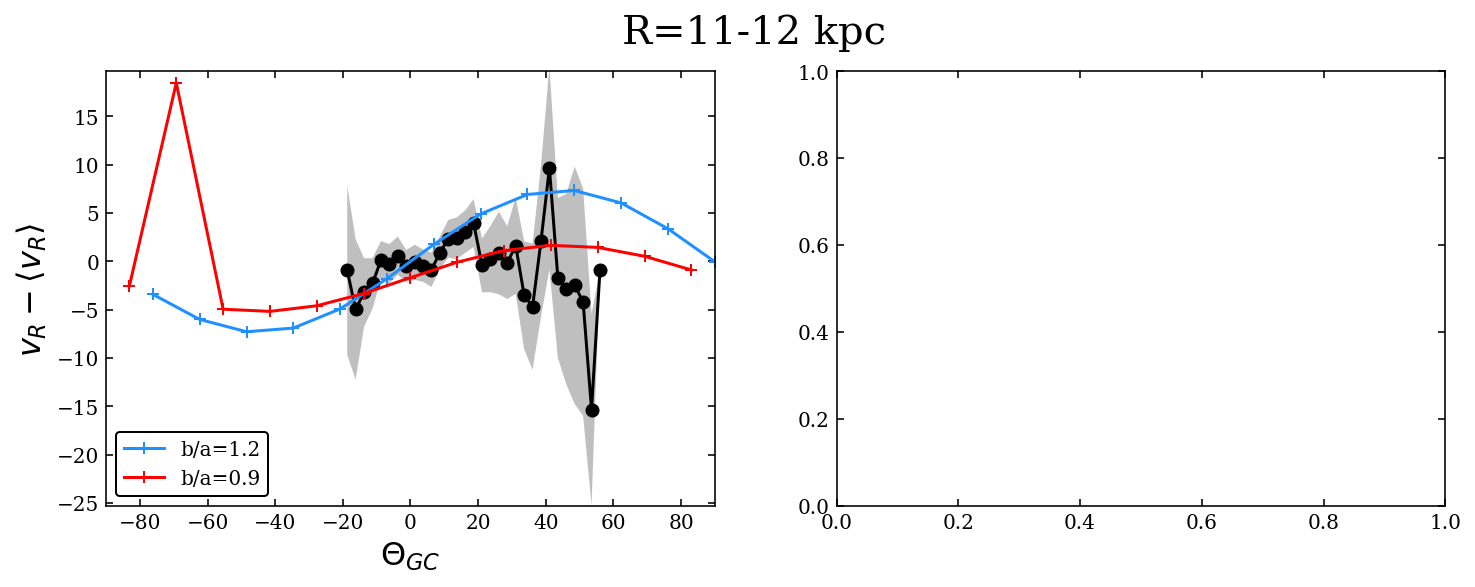

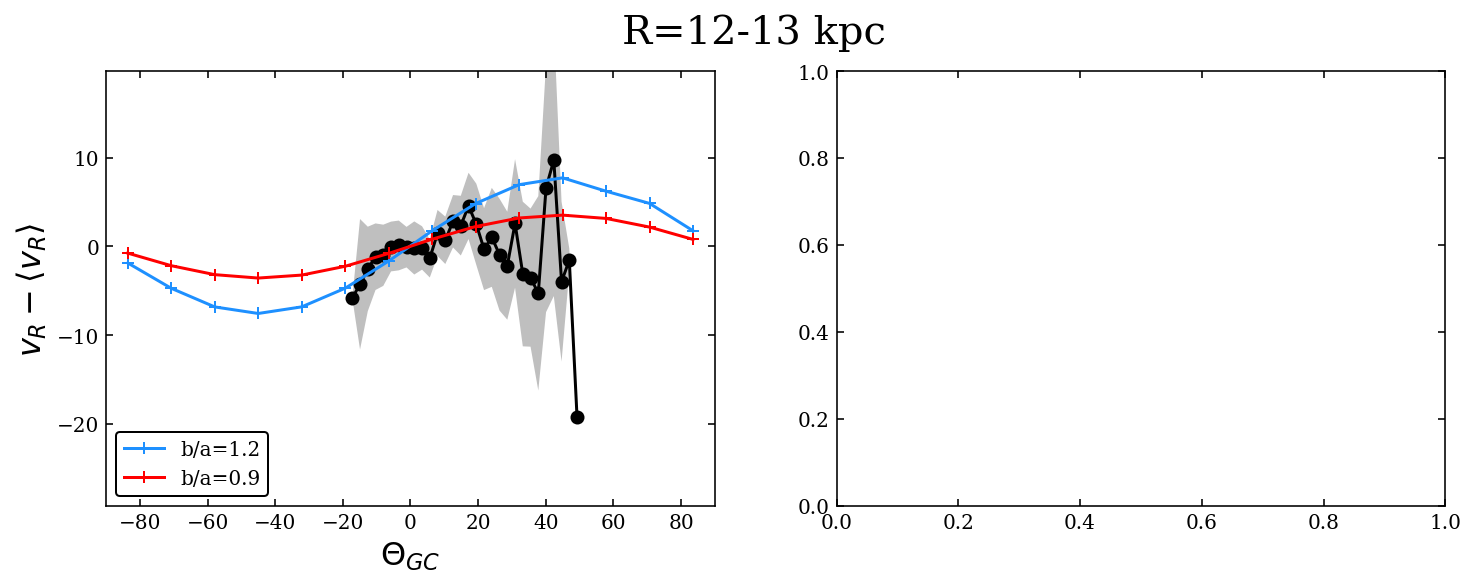

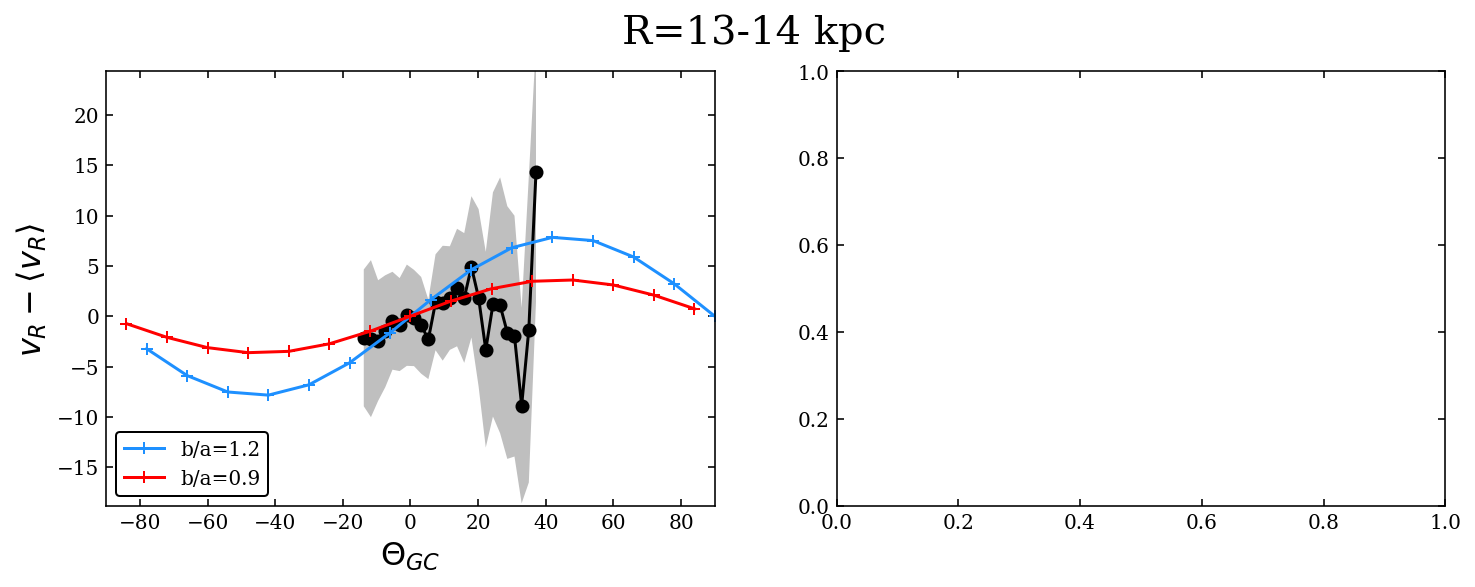

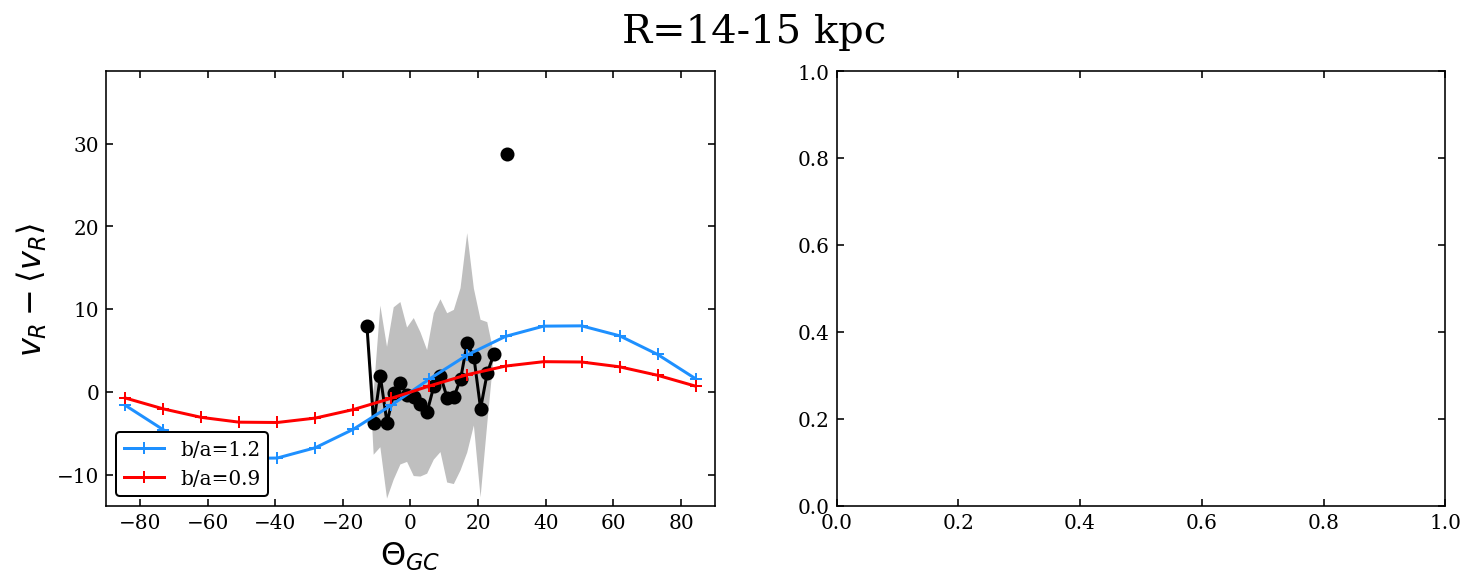

In [112]:
# Now loop over each radial bin
for i in range( len(R_range) ):
    
    # Bootstrap over the samples
    for j in range(n_bs):
        
        # Take a random sub-sample of Gaia stars
        sample = np.random.randint(0,len(gc_x),len(gc_x))
        samp_gc_R = gc_R[sample]
        samp_gc_az = gc_phi[sample]
        samp_gc_vR = gc_vR[sample]
        
        # Select the stars in this bin
        stars_in_bin = np.where(  (samp_gc_R > R_range[i]) & (samp_gc_R < (R_range[i]+R_bin_size) ) )[0]
        gcvr_in_bin = -gc_vR[stars_in_bin]
        gcaz_in_bin = gc_az[stars_in_bin]

        # Figure out the angular size of 0.5 kpc
        spec_az_size = 0.5/(R_range[i]+R_bin_size/2)
        n_az_bins = int( np.pi/180*(az_range[-1]-az_range[0]) /spec_az_size )
        az_low = -int(n_az_bins/2)*spec_az_size * 180/np.pi
        az_hi = (n_az_bins-int(n_az_bins/2))*spec_az_size * 180/np.pi

        # Bin in azimuth
        binned_vr, bin_edges, _ = binned_statistic(gcaz_in_bin, gcvr_in_bin, bins=n_az_bins, statistic='mean', 
                                                   range=(az_low, az_hi))
        vr_bin_cents = ( bin_edges[:-1] + bin_edges[1:] ) / 2

        # Make a number histogram to examine whether there is enough stars for a valid measurement
        binned_n, binned_n_edges, = np.histogram(gcaz_in_bin, bins=n_az_bins, range=(az_low, az_hi))
        where_low_bin_numbers = np.where(binned_n < 10)
        binned_vr[where_low_bin_numbers] = np.nan

        # Find where there was data
        # pdb.set_trace()
        where_data = np.where( np.isfinite(binned_vr) )
        where_no_data = np.where( np.isnan(binned_vr) )
        binned_vr[ where_no_data ] = np.nan

        # Subtract off mean where non-zero
        mean_binned_vr = np.nanmean( binned_vr[where_data] )
        binned_vr = binned_vr - mean_binned_vr
#         binned_vr[where_no_data] = 0
    
        # Get the power spectrum
        ks, pk, phase = ast1501.fourier.psd(binned_vr, az_bin_size*np.pi/180, pad=True, return_phase=True)
        
        if j == 0:
            bs_az = np.zeros((n_bs, len(vr_bin_cents)))
            bs_vR = np.zeros((n_bs, len(binned_vr)))
            bs_k_vR = np.zeros((n_bs, len(ks)))
            bs_pk_vR = np.zeros((n_bs, len(pk)))
        ##fi
        bs_az[j] = vr_bin_cents
        bs_vR[j] = binned_vr
        bs_k_vR[j] = ks
        bs_pk_vR[j] = pk
    
    
    # Take the average and standard deviation of the azimuthal profile
    bs_avg_vR = np.nanmean(bs_vR, axis=0)
    bs_std_vR = np.nanstd(bs_vR, axis=0)
    
    # Take the average and standard deviation of the power spectrum
    bs_avg_pk_vR = np.nanmean(bs_pk_vR, axis=0)
    bs_std_pk_vR = np.nanstd(bs_pk_vR, axis=0)
    
    # Plot
    fig = plt.figure( figsize=(12,4) )
    ax1, ax2 = fig.subplots(nrows=1, ncols=2)
    
    ax1.plot(bs_az[0], bs_avg_vR, color='Black', marker='o')
    ax1.fill_between( bs_az[0], bs_avg_vR+bs_std_vR, bs_avg_vR-bs_std_vR, alpha=0.5, facecolor='Grey' )
    
    ax1.set_xlabel(r'$\Theta_{GC}$', fontsize=16)
    ax1.set_ylabel(r'$v_{R}- \langle {v_{R}} \rangle$', fontsize=16)
    ax1.set_xlim(-90,90)
    ax1.set_ylim( np.nanmin(bs_avg_vR)-10, np.nanmax(bs_avg_vR)+10 )
    
    # Look for the simulation data
    index_radius = 0
    for k in range( sim_halo_data_b12.shape[0] ):
        if sim_halo_data_b12[k][0] == R_range_cents[i]:
            index_radius = k
        ##fi
    ###k
    
    sim_vr_data_b12 = sim_halo_data_b12[index_radius][2]
    sim_vr_data_b12 -= np.mean(sim_vr_data_b12)
    sim_az_data_b12 = sim_halo_data_b12[index_radius][1] * 180/np.pi
    
    # Apply a phase shift
    phase_shift = 90
    sim_az_data_b12 += phase_shift
    for l in range( len(sim_vr_data_b12) ):
        if sim_az_data_b12[l] >= 90:
            sim_az_data_b12[l] -= 180
        ##fi
    ###i
    sort_sim_az_data_b12 = np.argsort(sim_az_data_b12)
    sim_vr_data_b12 = sim_vr_data_b12[sort_sim_az_data_b12]
    sim_az_data_b12 = sim_az_data_b12[sort_sim_az_data_b12]
    
    ax1.plot(sim_az_data_b12, sim_vr_data_b12, color='DodgerBlue', marker='+', label='b/a=1.2')
    
    
    
    # Look for the simulation data
    index_radius = 0
    for k in range( sim_halo_data_b09.shape[0] ):
        if sim_halo_data_b09[k][0] == R_range_cents[i]:
            index_radius = k
        ##fi
    ###k
    
    sim_vr_data_b09 = sim_halo_data_b09[index_radius][2]
    sim_vr_data_b09 -= np.mean(sim_vr_data_b09)
    sim_az_data_b09 = sim_halo_data_b09[index_radius][1] * 180/np.pi
    
    # Apply a phase shift
    phase_shift = 0
    sim_az_data_b09 += phase_shift
    for l in range( len(sim_vr_data_b09) ):
        if sim_az_data_b09[l] >= 90:
            sim_az_data_b09[l] -= 180
        ##fi
    ###i
    sort_sim_az_data_b09 = np.argsort(sim_az_data_b09)
    sim_vr_data_b09 = sim_vr_data_b09[sort_sim_az_data_b09]
    sim_az_data_b09 = sim_az_data_b09[sort_sim_az_data_b09]
    
    ax1.plot(sim_az_data_b09, sim_vr_data_b09, color='Red', marker='+', label='b/a=0.9')
    
    ax1.legend(loc='lower left')
    
#     ax2.plot(np.log10(ks[round(len(ks)/2)+1:]), np.sqrt(4*np.pi*pk[round(len(ks)/2)+1:]), color='Black', marker='o')
#     ax2.set_xlabel(r'$k$', fontsize=16)
#     ax2.set_ylabel('Power', fontsize=16)
#     ax2.set_ylim(0,10)
    
#     ax3.plot( np.log10(ks[round(len(ks)/2)+1:]), phase[round(len(ks)/2)+1:], color='Black', marker='o')
#     ax3.set_xlabel(r'$k$', fontsize=16)
#     ax3.set_ylabel('Phase', fontsize=16)
    
    fig.suptitle('R='+str(int(R_range[i]))+'-'+str(int(R_range[i]+R_bin_size))+' kpc', fontsize=20)
    
    plt.show()
    plt.close('all')
###i

## Now examine Tangential Velocity profile with a cosine fit

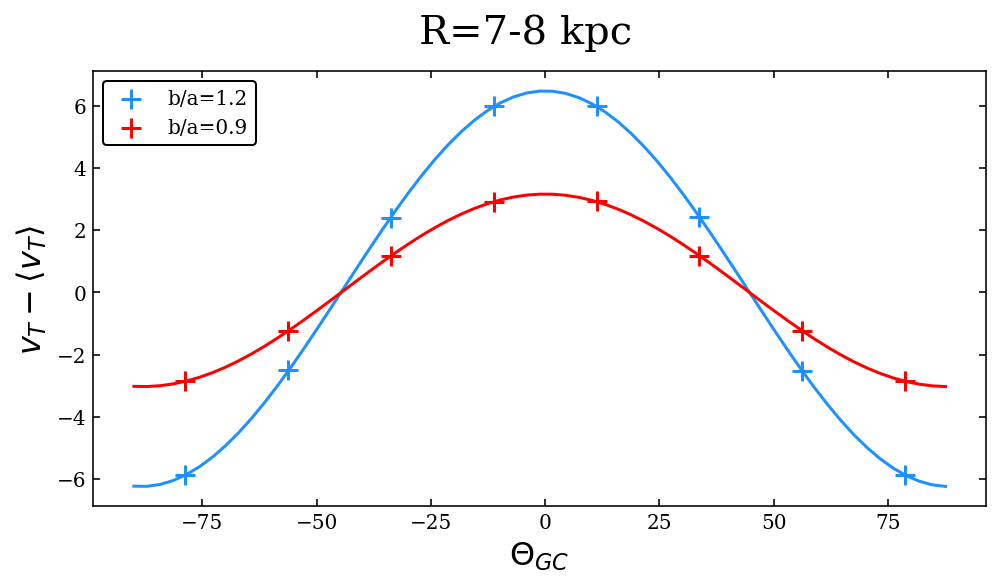

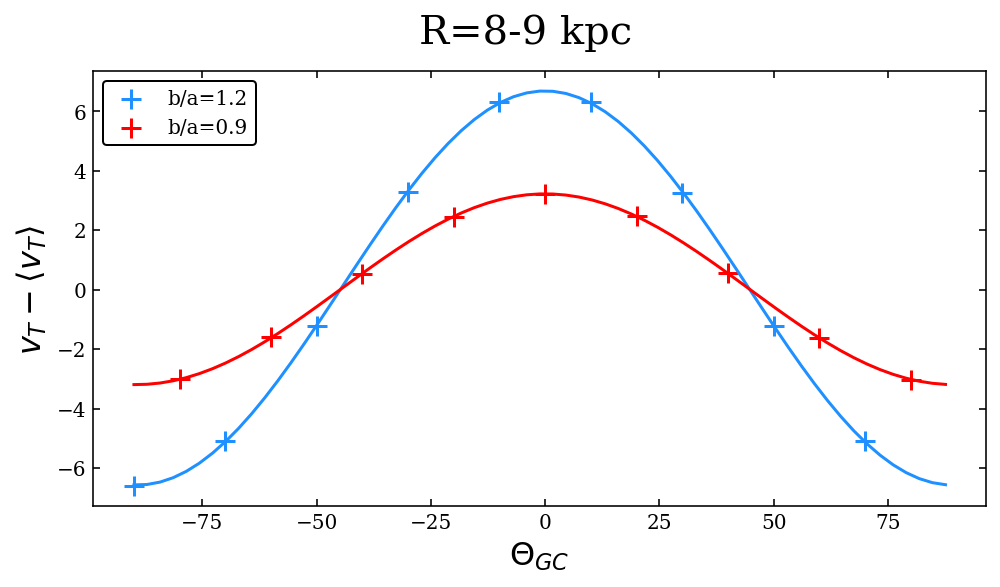

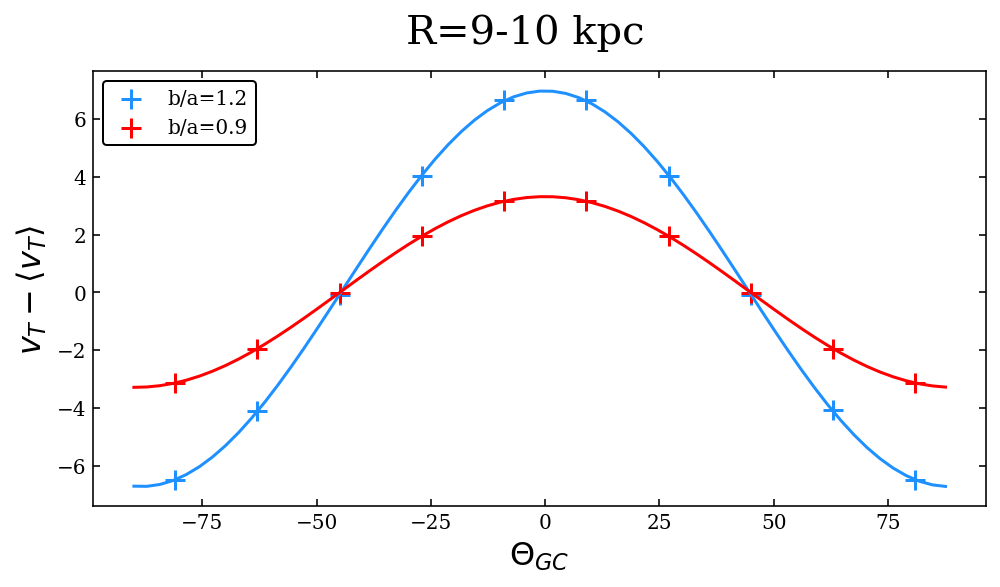

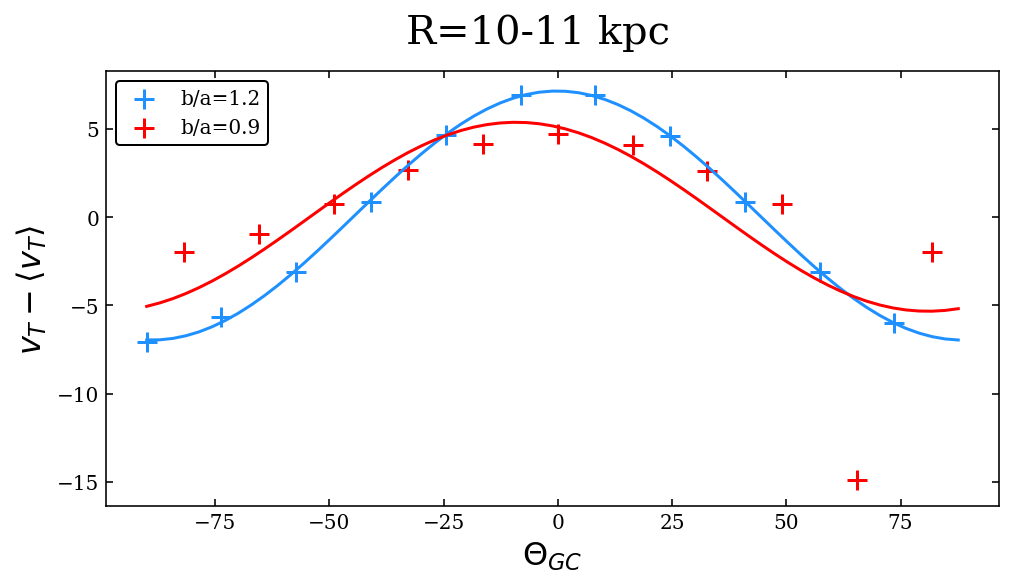

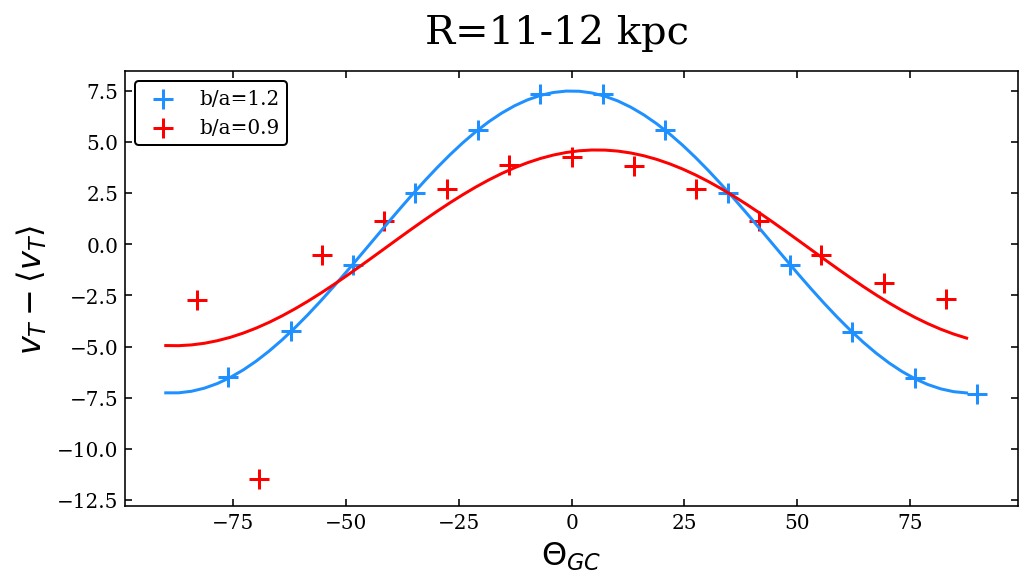

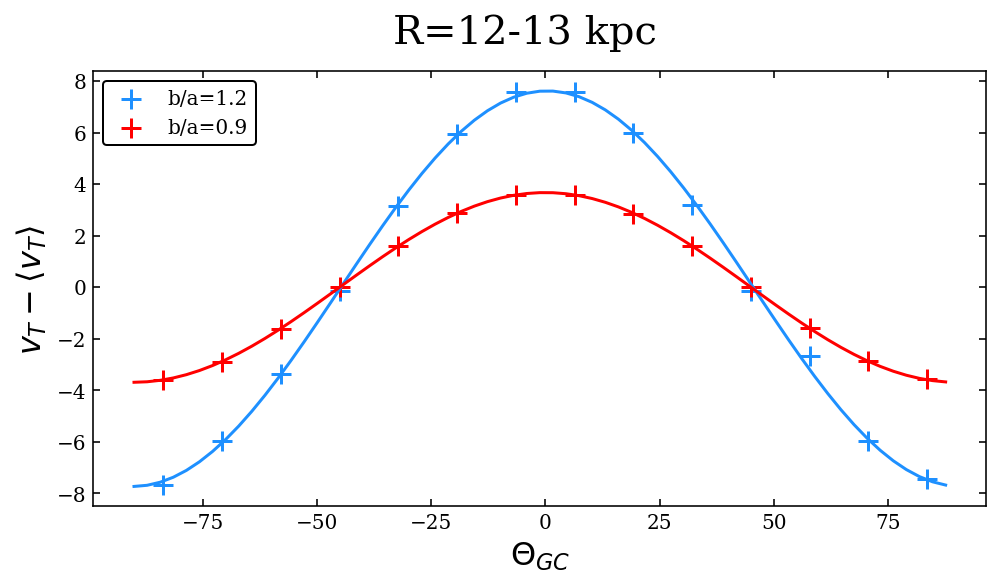

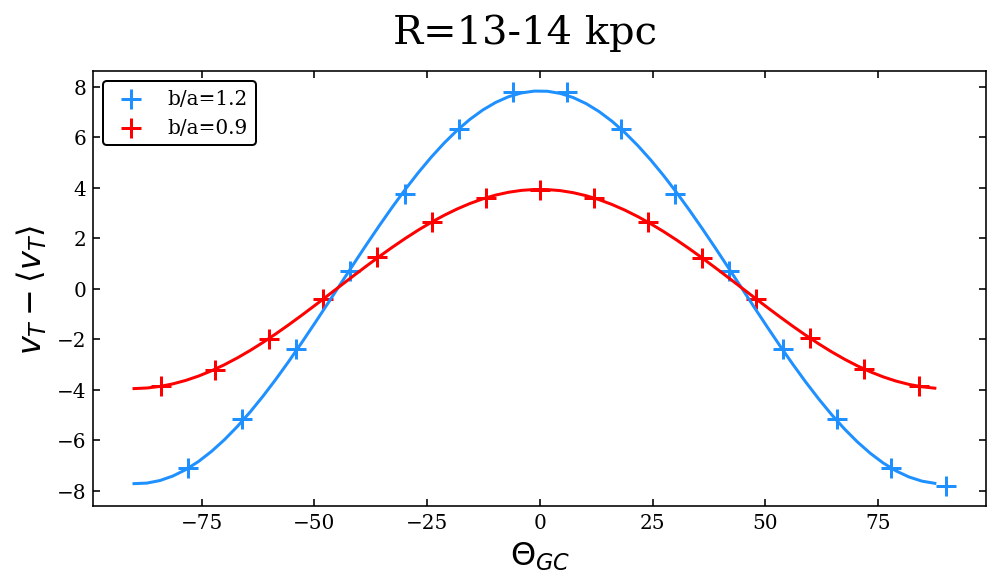

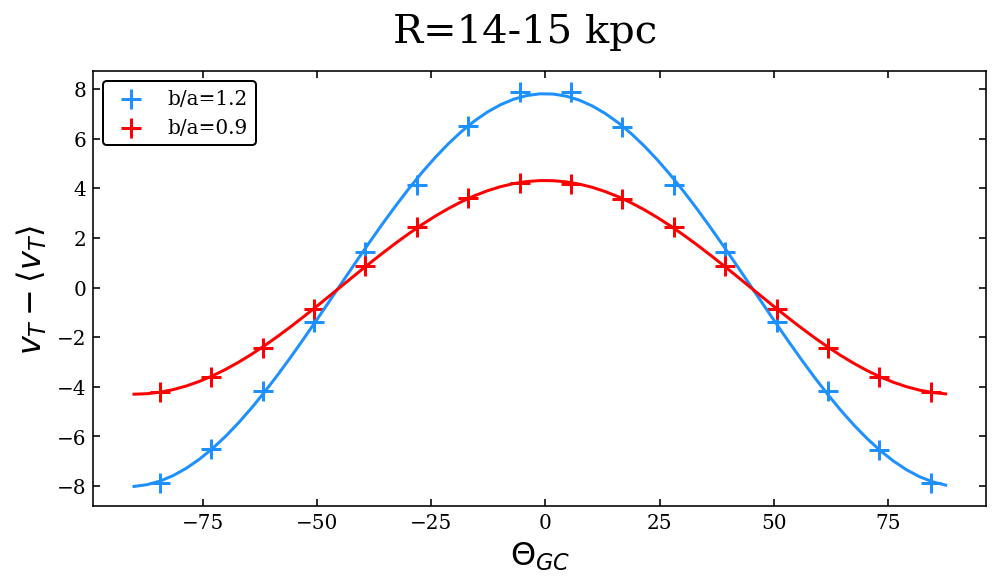

In [114]:
# Define the sinusoid fitting function:
def sinusoid(x,A,om,phase,D):
    return A*np.cos(om*x + phase) + D
#def

# Now loop over each radial bin
for i in range( len(R_range) ):
    
    # Plot
    fig = plt.figure( figsize=(8,4) )
    ax1 = fig.subplots(nrows=1, ncols=1)
    
    # Look for the simulation data
    index_radius = 0
    for k in range( sim_halo_data_b12.shape[0] ):
        if sim_halo_data_b12[k][0] == R_range_cents[i]:
            index_radius = k
        ##fi
    ###k
    
    sim_vt_data_b12 = sim_halo_data_b12[index_radius][3]
    sim_vt_data_b12 -= np.mean(sim_vt_data_b12)
    sim_az_data_b12 = sim_halo_data_b12[index_radius][1] * 180/np.pi
    
    # Apply a phase shift
    phase_shift = 90
    sim_az_data_b12 += phase_shift
    for l in range( len(sim_vt_data_b12) ):
        if sim_az_data_b12[l] >= 90:
            sim_az_data_b12[l] -= 180
        ##fi
    ###i
    sort_sim_az_data_b12 = np.argsort(sim_az_data_b12)
    sim_vt_data_b12 = sim_vt_data_b12[sort_sim_az_data_b12]
    sim_az_data_b12 = sim_az_data_b12[sort_sim_az_data_b12]
    
    ax1.scatter(sim_az_data_b12, sim_vt_data_b12, color='DodgerBlue', marker='+', label='b/a=1.2', s=100)
    
    
    # Now fit the averaged sample
    popt, pcov = curve_fit(sinusoid, sim_az_data_b12*np.pi/180, sim_vt_data_b12, p0=[10,2.,0.,0], ftol=0.01)
    
    # Now plot the averaged sample and the fitted curve
    ax1.plot( np.arange(-np.pi/2,np.pi/2,0.05)*180/np.pi, sinusoid(np.arange(-np.pi/2,np.pi/2,0.05), *popt), 
                  color='DodgerBlue', linestyle='solid')
    
    
    
    # Look for the simulation data
    index_radius = 0
    for k in range( sim_halo_data_b09.shape[0] ):
        if sim_halo_data_b09[k][0] == R_range_cents[i]:
            index_radius = k
        ##fi
    ###k
    
    sim_vt_data_b09 = sim_halo_data_b09[index_radius][3]
    sim_vt_data_b09 -= np.mean(sim_vt_data_b09)
    sim_az_data_b09 = sim_halo_data_b09[index_radius][1] * 180/np.pi
    
    # Apply a phase shift
    phase_shift = 0
    sim_az_data_b09 += phase_shift
    for l in range( len(sim_vt_data_b09) ):
        if sim_az_data_b09[l] >= 90:
            sim_az_data_b09[l] -= 180
        ##fi
    ###i
    sort_sim_az_data_b09 = np.argsort(sim_az_data_b09)
    sim_vt_data_b09 = sim_vt_data_b09[sort_sim_az_data_b09]
    sim_az_data_b09 = sim_az_data_b09[sort_sim_az_data_b09]
    
    ax1.scatter(sim_az_data_b09, sim_vt_data_b09, color='Red', marker='+', label='b/a=0.9', s=100)
    
    
    # Now fit the averaged sample
    popt, pcov = curve_fit(sinusoid, sim_az_data_b09*np.pi/180, sim_vt_data_b09, p0=[10,2.,0.,0], ftol=0.01)
    
    # Now plot the averaged sample and the fitted curve
    ax1.plot( np.arange(-np.pi/2,np.pi/2,0.05)*180/np.pi, sinusoid(np.arange(-np.pi/2,np.pi/2,0.05), *popt), 
                  color='Red', linestyle='solid')
    
    ax1.legend(loc='upper left')
    ax1.set_xlabel(r'$\Theta_{GC}$', fontsize=16)
    ax1.set_ylabel(r'$v_{T}- \langle {v_{T}} \rangle$', fontsize=16)
    
    fig.suptitle('R='+str(int(R_range[i]))+'-'+str(int(R_range[i]+R_bin_size))+' kpc', fontsize=20)
    
    plt.show()
    plt.close('all')

## Now examine Radial Velocity profile with a cosine fit

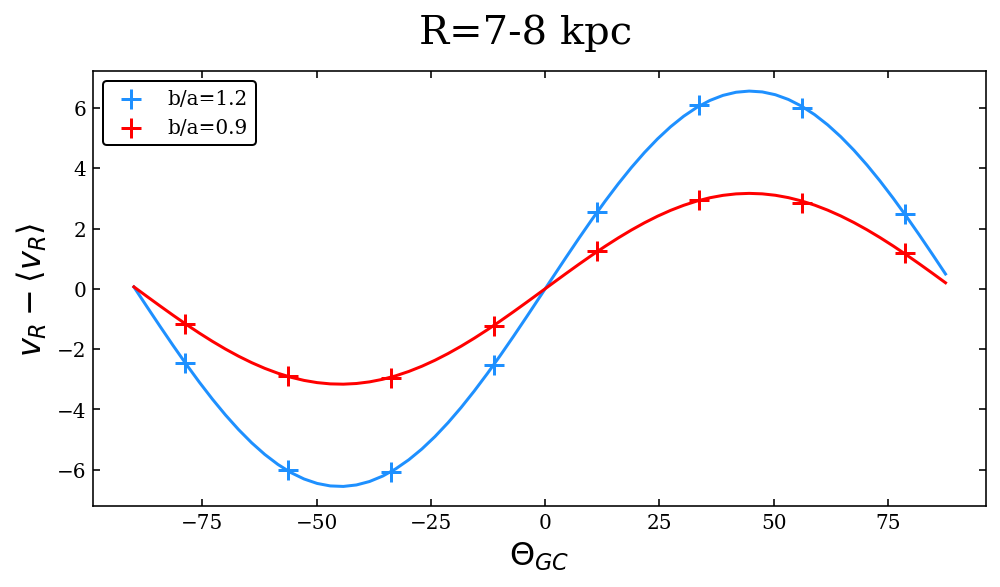

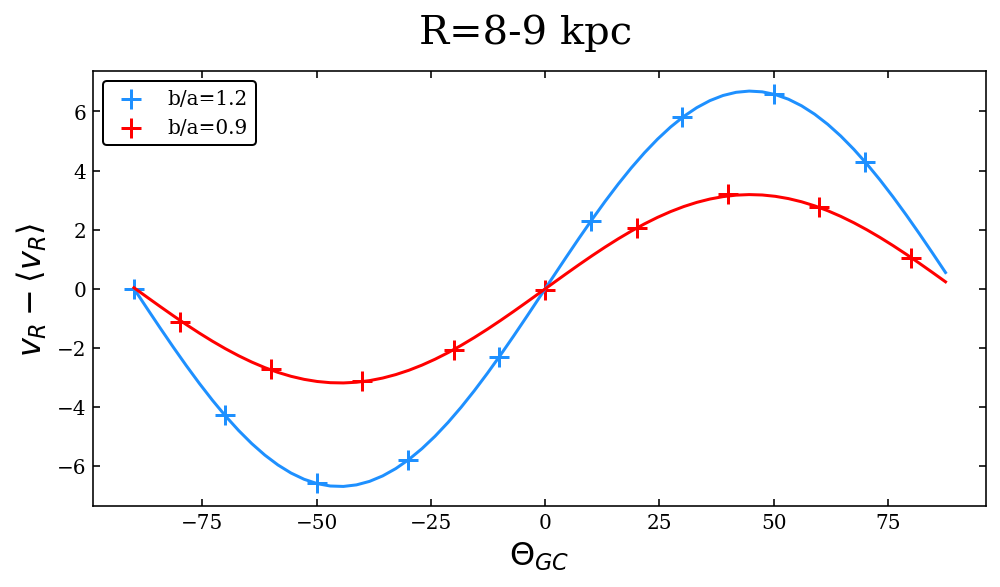

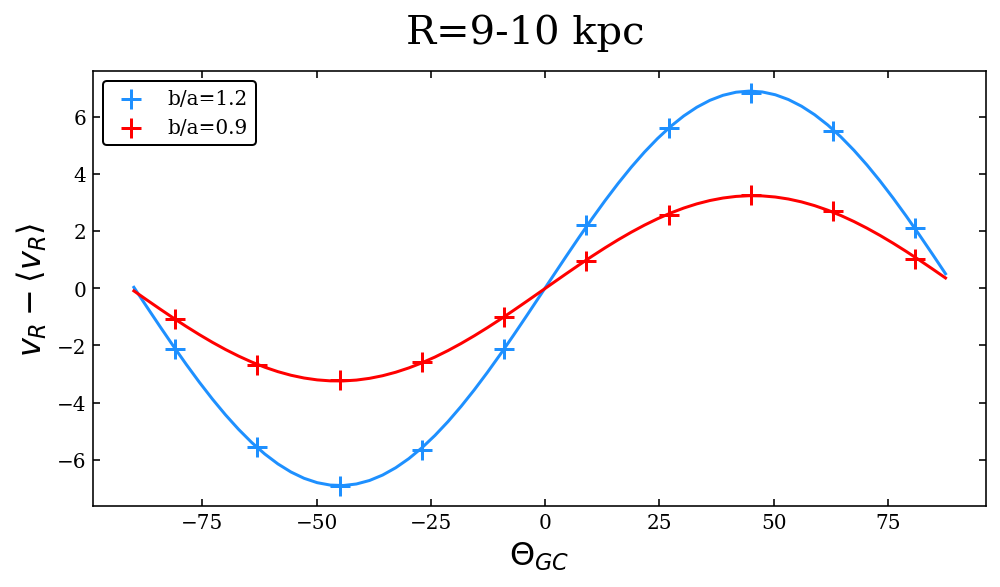

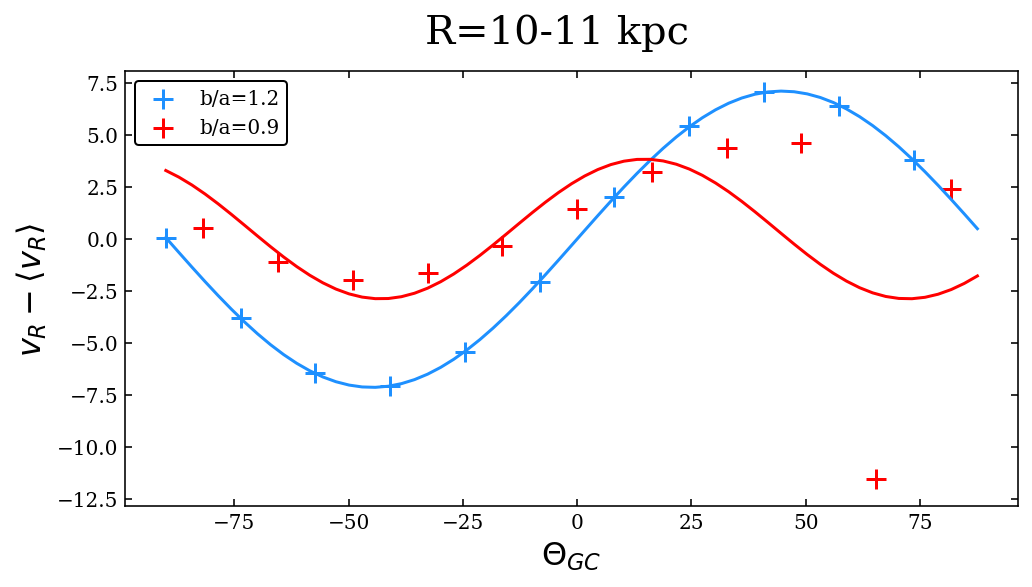

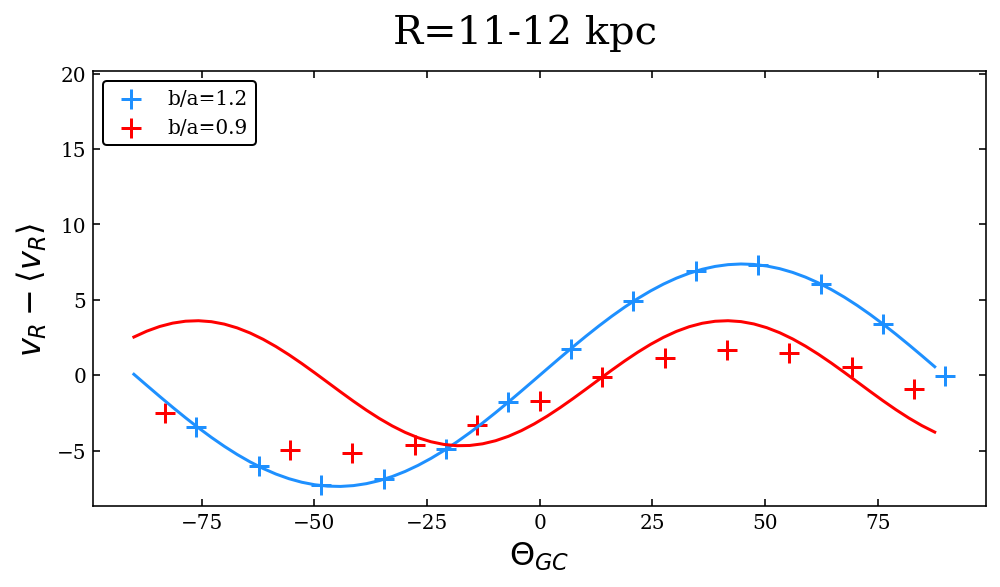

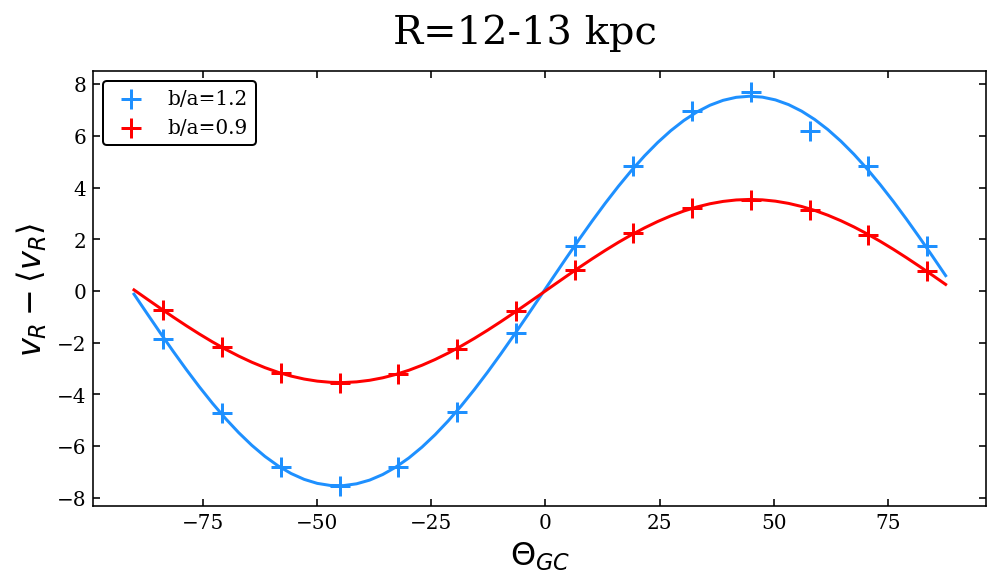

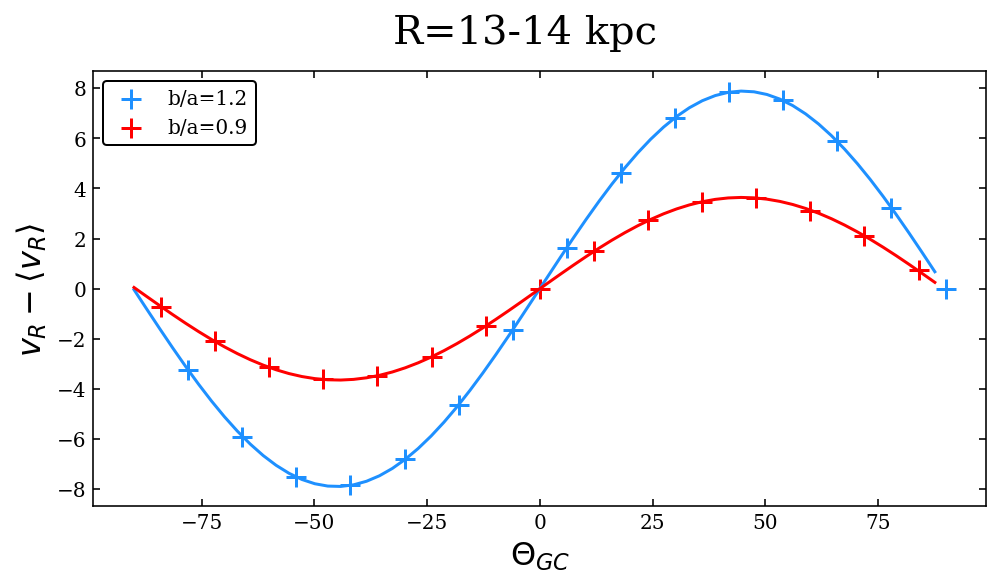

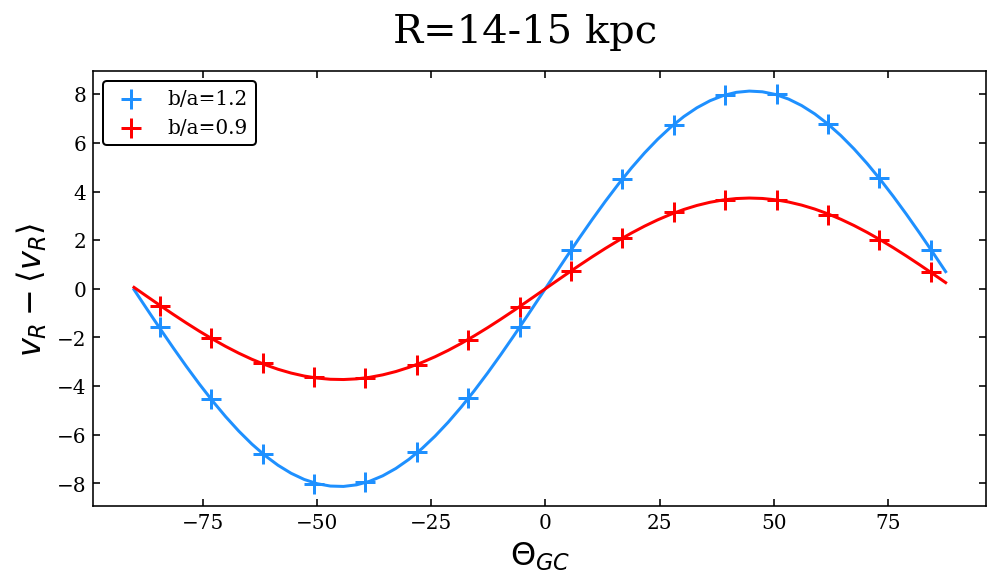

In [115]:
# Define the sinusoid fitting function:
def sinusoid(x,A,om,phase,D):
    return A*np.cos(om*x + phase) + D
#def

# Now loop over each radial bin
for i in range( len(R_range) ):
    
    # Plot
    fig = plt.figure( figsize=(8,4) )
    ax1 = fig.subplots(nrows=1, ncols=1)
    
    # Look for the simulation data
    index_radius = 0
    for k in range( sim_halo_data_b12.shape[0] ):
        if sim_halo_data_b12[k][0] == R_range_cents[i]:
            index_radius = k
        ##fi
    ###k
    
    sim_vr_data_b12 = sim_halo_data_b12[index_radius][2]
    sim_vr_data_b12 -= np.mean(sim_vr_data_b12)
    sim_az_data_b12 = sim_halo_data_b12[index_radius][1] * 180/np.pi
    
    # Apply a phase shift
    phase_shift = 90
    sim_az_data_b12 += phase_shift
    for l in range( len(sim_vr_data_b12) ):
        if sim_az_data_b12[l] >= 90:
            sim_az_data_b12[l] -= 180
        ##fi
    ###i
    sort_sim_az_data_b12 = np.argsort(sim_az_data_b12)
    sim_vr_data_b12 = sim_vr_data_b12[sort_sim_az_data_b12]
    sim_az_data_b12 = sim_az_data_b12[sort_sim_az_data_b12]
    
    ax1.scatter(sim_az_data_b12, sim_vr_data_b12, color='DodgerBlue', marker='+', label='b/a=1.2', s=100)
    
    
    # Now fit the averaged sample
    popt, pcov = curve_fit(sinusoid, sim_az_data_b12*np.pi/180, sim_vr_data_b12, p0=[10,2.,0.,0], ftol=0.01)
    
    # Now plot the averaged sample and the fitted curve
    ax1.plot( np.arange(-np.pi/2,np.pi/2,0.05)*180/np.pi, sinusoid(np.arange(-np.pi/2,np.pi/2,0.05), *popt), 
                  color='DodgerBlue', linestyle='solid')
    
    
    
    # Look for the simulation data
    index_radius = 0
    for k in range( sim_halo_data_b09.shape[0] ):
        if sim_halo_data_b09[k][0] == R_range_cents[i]:
            index_radius = k
        ##fi
    ###k
    
    sim_vr_data_b09 = sim_halo_data_b09[index_radius][2]
    sim_vr_data_b09 -= np.mean(sim_vr_data_b09)
    sim_az_data_b09 = sim_halo_data_b09[index_radius][1] * 180/np.pi
    
    # Apply a phase shift
    phase_shift = 0
    sim_az_data_b09 += phase_shift
    for l in range( len(sim_vr_data_b09) ):
        if sim_az_data_b09[l] >= 90:
            sim_az_data_b09[l] -= 180
        ##fi
    ###i
    sort_sim_az_data_b09 = np.argsort(sim_az_data_b09)
    sim_vr_data_b09 = sim_vr_data_b09[sort_sim_az_data_b09]
    sim_az_data_b09 = sim_az_data_b09[sort_sim_az_data_b09]
    
    ax1.scatter(sim_az_data_b09, sim_vr_data_b09, color='Red', marker='+', label='b/a=0.9', s=100)
    
    
    # Now fit the averaged sample
    popt, pcov = curve_fit(sinusoid, sim_az_data_b09*np.pi/180, sim_vr_data_b09, p0=[10,2.,0.,0], ftol=0.01)
    
    # Now plot the averaged sample and the fitted curve
    ax1.plot( np.arange(-np.pi/2,np.pi/2,0.05)*180/np.pi, sinusoid(np.arange(-np.pi/2,np.pi/2,0.05), *popt), 
                  color='Red', linestyle='solid')
    
    ax1.legend(loc='upper left')
    
    ax1.set_xlabel(r'$\Theta_{GC}$', fontsize=16)
    ax1.set_ylabel(r'$v_{R}- \langle {v_{R}} \rangle$', fontsize=16)
    
    fig.suptitle('R='+str(int(R_range[i]))+'-'+str(int(R_range[i]+R_bin_size))+' kpc', fontsize=20)
    
    plt.show()
    plt.close('all')